# Dissertation Progress Presentation: Demonstration 19 February 2018

This document demonstrates the following:
* Demonstration of the libraries created for my dissertation
* Some spatial optimization implementations
* Some spatial analyses motivating future work

# Contents
* [Imports](#Imports)
* [Data Setup](#Data-Setup)
* [Create AOI and Parameters](#Create-AOI-and-Parameters)
* [Airfield Objective](#Airfield-Objective)
 * [Site Suitability](#Site-Suitability)
 * [Site Configuration](#Site-Configuration)
 * [Site Evaluation](#Site-Evaluation)
* [Camp 1 Objective](#Camp-1-Objective)
* [Camp 2 Objective](#Camp-2-Objective)
* [Site Relations](#Site-Relations)

# Imports

In [1]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import random
%matplotlib inline
pd.options.display.max_columns = 200
reload(pgdissroute)
reload(firstpass)
reload(io)

<module 'SpatialIO' from 'SpatialIO.pyc'>

# Data Setup

In [2]:
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"
vector_path = './test_data/UtilityInfrastructureCrv_3.shp'
roadsPath = './test_data/tgc.shp'
landcoverPath = '../FLW_Missouri Mission Folder/RASTER/LC_LandCover_GeoCover_proj.tif'

# Create AOI and Parameters

Text(0.5,0.98,u'Areas of Interest')

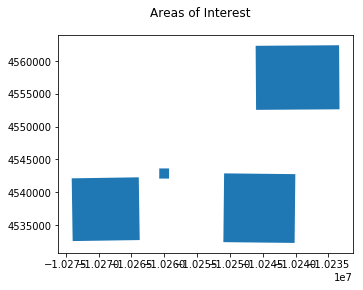

In [3]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()
plt.suptitle("Areas of Interest")

# Airfield Objective

## Site Suitability

In [4]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)

Generated 12161 squares in 0 seconds


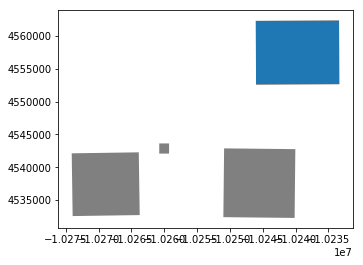

In [5]:
airfieldEvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))

In [6]:
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)


/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

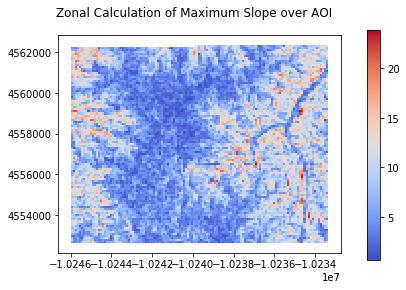

In [7]:
vmin = min(airfieldSlopeEvaluationDataFrame['max'])
vmax = max(airfieldSlopeEvaluationDataFrame['max'])
ax = airfieldSlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

Text(0,0.5,u'Fraction of AOI Evaluation Grid')

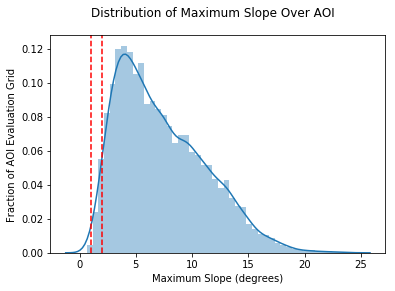

In [8]:
sns.distplot(airfieldSlopeEvaluationDataFrame['max'])
plt.axvline(1, color='red', linestyle='--')
plt.axvline(2, color='red', linestyle='--')
plt.suptitle("Distribution of Maximum Slope Over AOI")
plt.xlabel("Maximum Slope (degrees)")
plt.ylabel("Fraction of AOI Evaluation Grid")

**Subset by maximum slope < 2**

In [9]:
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
print "Subset consists of %s areas, reduced from the original %s areas" %(len(airfieldSlopeEvaluationDataFrameSubset.index),len(airfieldSlopeEvaluationDataFrame.index))

Subset consists of 364 areas, reduced from the original 12161 areas


Text(0.5,0.98,u'New Evaluation Areas')

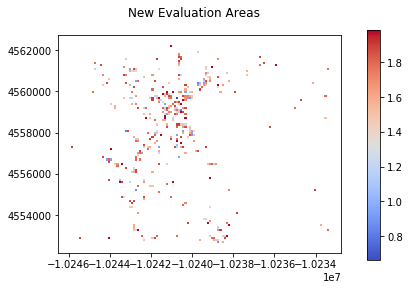

In [10]:
vmin = min(airfieldSlopeEvaluationDataFrameSubset['max'])
vmax = max(airfieldSlopeEvaluationDataFrameSubset['max'])
ax = airfieldSlopeEvaluationDataFrameSubset.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("New Evaluation Areas")

**Create Larger Candidate Sites Using the Simplified Approach**

**Distance to Linear Features**

In [11]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

In [12]:
lx,ly,ux,uy = airfieldEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

Text(0.5,0.98,u'Roads Near the AOI')

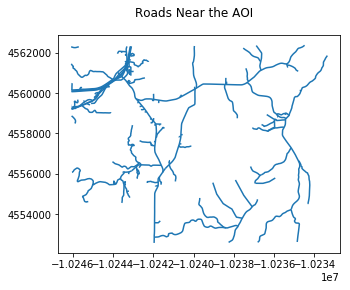

In [13]:
roadsDF.plot()
plt.suptitle("Roads Near the AOI")

In [14]:
airfieldEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(airfieldEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

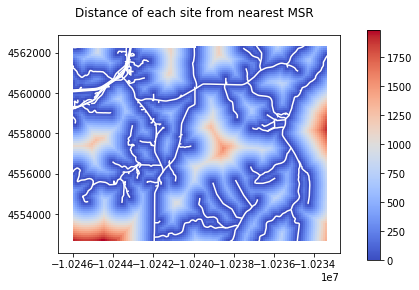

In [15]:
vmin = min(airfieldEvaluationDataFrame['distance'])
vmax = max(airfieldEvaluationDataFrame['distance'])
ax = airfieldEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

Text(0,0.5,u'Fraction of Candidate Sites')

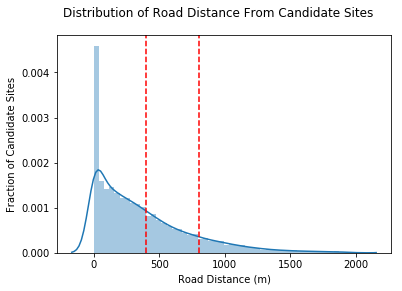

In [16]:
sns.distplot(airfieldEvaluationDataFrame['distance'])
plt.axvline(400, color='red', linestyle='--')
plt.axvline(800, color='red', linestyle='--')
plt.suptitle("Distribution of Road Distance From Candidate Sites")
plt.xlabel("Road Distance (m)")
plt.ylabel("Fraction of Candidate Sites")

## Site Configuration

In [17]:
largerPolygonDimension = 800
largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, largerPolygonDimension)

Text(0.5,0.98,u'Site Configuration for Airfield')

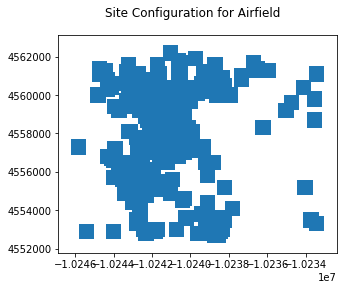

In [18]:
largerAirfields.plot()
plt.suptitle("Site Configuration for Airfield")

## Site Evaluation

**Calculate Cut Fill For Objective Function**

In [19]:
cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=1)

Text(0.5,0.98,u'Cut Fill Required for Candidate Airfields (m^3)')

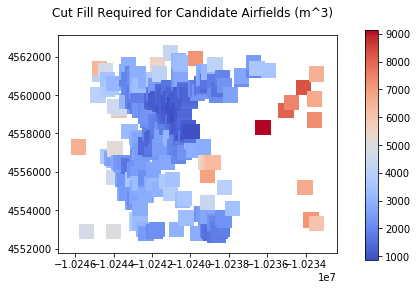

In [20]:
vmin = min(cutFillDF['totalCutFillVolume'])
vmax = max(cutFillDF['totalCutFillVolume'])
ax = cutFillDF.plot(column='totalCutFillVolume', cmap='coolwarm', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Cut Fill Required for Candidate Airfields (m^3)")

Text(0,0.5,u'Fraction of Candidate Sites')

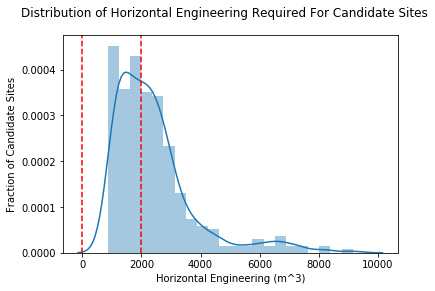

In [21]:
sns.distplot(cutFillDF['totalCutFillVolume'])
plt.axvline(0, color='red', linestyle='--')
plt.axvline(2000, color='red', linestyle='--')
plt.suptitle("Distribution of Horizontal Engineering Required For Candidate Sites")
plt.xlabel("Horizontal Engineering (m^3)")
plt.ylabel("Fraction of Candidate Sites")

# Camp 1 Objective

In [22]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

Generated 9551 squares in 0 seconds


Text(0.5,0.98,u'Context: Location of Site 1')

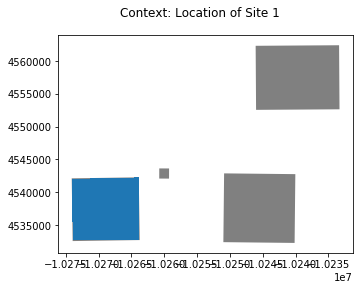

In [23]:
baseObjective1EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 1")

In [24]:
site1SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective1EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

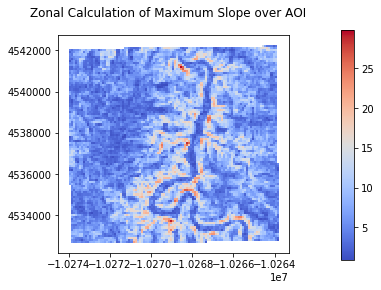

In [25]:
vmin = min(site1SlopeEvaluationDataFrame['max'])
vmax = max(site1SlopeEvaluationDataFrame['max'])
ax = site1SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [26]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site1SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site1SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site1SlopeEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

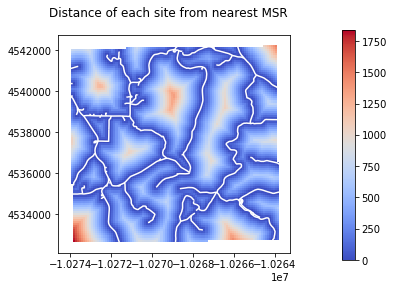

In [27]:
vmin = min(site1SlopeEvaluationDataFrame['distance'])
vmax = max(site1SlopeEvaluationDataFrame['distance'])
ax = site1SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Camp 2 Objective

In [28]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

Generated 11141 squares in 0 seconds


Text(0.5,0.98,u'Context: Location of Site 2')

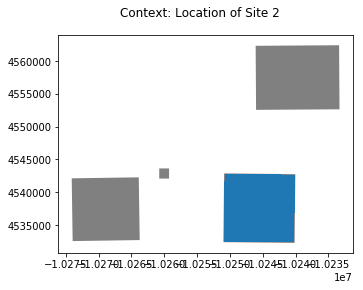

In [29]:
baseObjective2EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 2")

In [30]:
site2SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective2EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

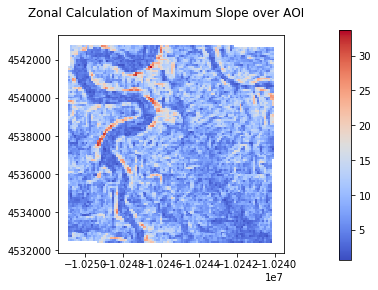

In [31]:
vmin = min(site2SlopeEvaluationDataFrame['max'])
vmax = max(site2SlopeEvaluationDataFrame['max'])
ax = site2SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [32]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site2SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site2SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site2SlopeEvaluationDataFrame,roadsDF)

Text(0.5,0.98,u'Distance of each site from nearest MSR')

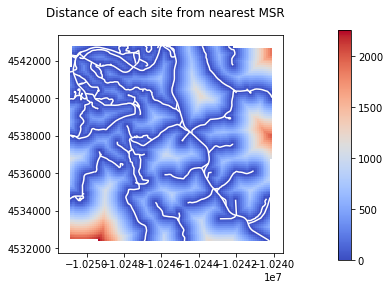

In [33]:
vmin = min(site2SlopeEvaluationDataFrame['distance'])
vmax = max(site2SlopeEvaluationDataFrame['distance'])
ax = site2SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Site Relations

**Set Up Three Candidate Solution DataFrames**

In [34]:
airfieldCandidates = cutFillDF[cutFillDF['totalCutFillVolume'] < 2000]
print "Evaluating %s candidates for the airfield site" %(len(airfieldCandidates.index))

Evaluating 170 candidates for the airfield site


In [35]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site1Candidates.index),100)
site1Candidates = site1Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site1Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site1Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site1Candidates.index))

Evaluating 100 candidates for the Site 1


In [36]:
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site2Candidates.index),100)
site2Candidates = site2Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site2Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site2Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site2Candidates.index))

Evaluating 100 candidates for the Site 1


Text(0.5,0.98,u'Candidate Sites for Relational Analysis')

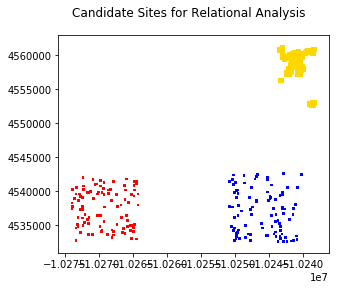

In [37]:
airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))
plt.suptitle("Candidate Sites for Relational Analysis")

In [224]:
class CandidateSolution:
    def __init__(self,geom1,geom2,geom3):
        self.geom1 = geom1
        self.geom2 = geom2
        self.geom3 = geom3

In [38]:
# generate solutionDF at random
geomDF = site1Candidates
geomDF.crs = {'init':'EPSG:3857'}
geomDF = geomDF.to_crs({'init':'EPSG:4326'})
heat_data1 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geomDF.index))
        randomCandidate = geomDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data1.append(generation)
        

In [39]:
geom2DF = site2Candidates
geom2DF.crs = {'init':'EPSG:3857'}
geom2DF = geom2DF.to_crs({'init':'EPSG:4326'})
heat_data2 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = geom2DF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data2.append(generation)

In [40]:
airfieldDF = airfieldCandidates
airfieldDF.crs = {'init':'EPSG:3857'}
airfieldDF = airfieldDF.to_crs({'init':'EPSG:4326'})
heat_data3 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = airfieldDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data3.append(generation)

In [43]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [44]:
weights=(-1.0,-1.0)
creator.create("FitnessMin", base.Fitness, weights=weights)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [88]:
def evaluate(individual):
    try:
        # retreive geometries
        airfieldCandidate = airfieldDF
        airfieldCandidate.crs = {'init':'EPSG:3857'}
        airfieldCandidate = airfieldCandidate.to_crs({'init':'EPSG:4326'})
        airfieldCandidate = airfieldDF.iloc[individual[0],:]
        airfieldCentroidLon = float(airfieldCandidate['geometry'].centroid.x)
        airfieldCentroidLat = float(airfieldCandidate['geometry'].centroid.y)

        redCandidate = geomDF
        redCandidate.crs = {'init':'EPSG:3857'}
        redCandidate = redCandidate.to_crs({'init':'EPSG:4326'})
        redCandidate = geomDF.iloc[individual[1],:]
        redCentroidLon = float(redCandidate['geometry'].centroid.x)
        redCentroidLat = float(redCandidate['geometry'].centroid.y)

        blueCandidate = geom2DF
        blueCandidate.crs = {'init':'EPSG:3857'}
        blueCandidate = blueCandidate.to_crs({'init':'EPSG:4326'})
        blueCandidate = geom2DF.iloc[individual[2],:]
        blueCentroidLon = float(blueCandidate['geometry'].centroid.x)
        blueCentroidLat = float(blueCandidate['geometry'].centroid.y)

        # distance from airfield to site red
        redToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,redCentroidLon,redCentroidLat)
        # distance from airfield to site blue
        blueToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,blueCentroidLon,blueCentroidLat)

        # print for debugging
        print "red is %s m from airfield, at (%s,%s)" %(redToAirfieldDistance,redCentroidLon,redCentroidLat)
        print "blue is %s m from airfield, at (%s,%s)" %(blueToAirfieldDistance,blueCentroidLon,blueCentroidLat)
        return redToAirfieldDistance, blueToAirfieldDistance

    except Exception, e:
        print "Generated an error, returning very large number"
        return 999999,999999
        
        
    

def mutate(individual,probElementMutation=0.1):
    attrDictionary = {0: (0, len(airfieldCandidates.index)),
                  1: (0,len(geomDF.index)),
                      2: (0,len(geom2DF.index))}# nopep8
    for i in range(0,len(individual)):
        attr = individual[i]
        shouldWeMutate = np.random.random() <= probElementMutation
        if shouldWeMutate:
            newAttrLowerBound = attrDictionary[i][0]
            newAttrUpperBound = attrDictionary[i][1]
            newAttrValue = np.random.randint(newAttrLowerBound,newAttrUpperBound)
            individual[i] = newAttrValue
    return (individual,)

def createPopulation(populationSize):
    toolbox.register("index1",random.randint,0,len(airfieldCandidates.index))
    toolbox.register("index2",random.randint,0,len(geomDF.index))
    toolbox.register("index3",random.randint,0,len(geom2DF.index))
    genes = [toolbox.index1,toolbox.index2,toolbox.index3]
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     genes, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    population = toolbox.population(n=populationSize)
    return population

In [102]:
popSize = 10
nGenerations = 10
pMutation = 0.1
pCrossover = 0.5
maxElite = 4

In [103]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selNSGA2)
population = createPopulation(popSize)
print population
hallOfFame = tools.ParetoFront()  
logbook = tools.Logbook()

[[39, 76, 75], [100, 35, 69], [31, 66, 90], [69, 1, 32], [64, 84, 44], [90, 96, 73], [66, 69, 91], [5, 71, 84], [14, 14, 96], [83, 2, 91]]


In [104]:
# perform the GA
stats = tools.Statistics(key= lambda ind: individual.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
for individual in population:
    individual.fitness.values = toolbox.evaluate(individual)
record = stats.compile(population)
hallOfFame.update(population)

for generation in range(0,nGenerations):
    print "GENERATION %s" %(generation)
    theBestIndividuals = []
    if len(hallOfFame.items) <= maxElite:
        theBestIndividuals = hallOfFame.items
    elif len(hallOfFame.items) > 0:
        theBestIndividuals = hallOfFame.items[0:maxElite]
    reducedOffspring = toolbox.select(population, len(population)-len(theBestIndividuals))
    offspring = theBestIndividuals + reducedOffspring   
   # Clone the selected individuals
    offspring = map(toolbox.clone, offspring)

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= pCrossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring, with a probability assigned to each gene  # nopep8
    for mutant in offspring:
        toolbox.mutate(mutant, pMutation)
        del mutant.fitness.values
    
     # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for individual in invalid_ind:
        individual.fitness.values = toolbox.evaluate(individual)
        
    # The population is entirely replaced by the offspring
    population[:] = offspring
    hallOfFame.update(population)
    record=stats.compile(population)
    
    allScores = []
    for individual in population: 
        allScores.append(individual.fitness.values)
            
    logbook.record(gen=generation, allIndividuals = list(population), allScores = allScores, top5 = theBestIndividuals[0], bestScore = theBestIndividuals[0].fitness.values,
                       **record)
    print theBestIndividuals[0], theBestIndividuals[0].fitness.values

red is 38119.8055237 m from airfield, at (-92.2115853793,37.6784434907)
blue is 16247.4501884 m from airfield, at (-92.0130166316,37.7389829209)
red is 41925.3547625 m from airfield, at (-92.2888404937,37.7125624324)
blue is 21034.5773249 m from airfield, at (-92.0794919627,37.7276157401)
red is 38749.4117761 m from airfield, at (-92.2789590256,37.7011911964)
blue is 22586.2864685 m from airfield, at (-92.0543391347,37.7041654188)
red is 37819.500671 m from airfield, at (-92.2376365225,37.6784434907)
blue is 29413.0136058 m from airfield, at (-92.0750003862,37.6728867793)
red is 39050.3186842 m from airfield, at (-92.2322466308,37.704744895)
blue is 23119.770012 m from airfield, at (-92.0228980998,37.6956361891)
red is 47954.991609 m from airfield, at (-92.2394331531,37.6720444414)
blue is 17743.0137808 m from airfield, at (-92.0507458736,37.7332995486)
red is 39393.6949943 m from airfield, at (-92.2915354396,37.704744895)
blue is 19634.2604094 m from airfield, at (-92.0291863067,37.72

red is 36958.2169072 m from airfield, at (-92.2151786404,37.6791544621)
blue is 20007.1060892 m from airfield, at (-92.0291863067,37.7269052334)
red is 39053.8432247 m from airfield, at (-92.2789590256,37.7139837142)
blue is 19948.5393894 m from airfield, at (-92.0507458736,37.7332995486)
red is 37348.4582017 m from airfield, at (-92.2376365225,37.6784434907)
blue is 21335.423232 m from airfield, at (-92.0776953321,37.7190892093)
red is 32143.0528519 m from airfield, at (-92.210687064,37.7154049688)
blue is 21749.4831953 m from airfield, at (-92.0543391347,37.7041654188)
red is 40796.7926836 m from airfield, at (-92.2529078824,37.7189579859)
blue is 23541.1014483 m from airfield, at (-92.0175082081,37.6728867793)
[9, 58, 90] (32143.052851943907, 21749.483195280038)
GENERATION 5
red is 31042.1237014 m from airfield, at (-92.210687064,37.7154049688)
blue is 19909.7300332 m from airfield, at (-92.0543391347,37.7041654188)
red is 36072.4243624 m from airfield, at (-92.2331449461,37.6855528

In [110]:
logbookDF = pd.DataFrame(logbook)
logbookDF.to_pickle("./results/tengeneration.pkl")

In [106]:
logbookDF

,allIndividuals,allScores,avg,bestScore,gen,max,min,std,top5
0,"[[14, 14, 75], [138, 76, 96], [14, 92, 65], [3...","[(35679.7690683, 13674.3442123), (35774.149676...",38238.202470,"(35679.7690683, 13674.3442123)",0,47676.557269,28799.847670,9438.354799,"[14, 14, 75]"
1,"[[14, 14, 98], [14, 14, 75], [69, 1, 73], [138...","[(35679.7690683, 21335.423232), (35679.7690683...",30518.400722,"(35679.7690683, 13674.3442123)",1,37857.369360,23179.432085,7338.968638,"[14, 14, 75]"
2,"[[14, 14, 75], [14, 7, 75], [69, 14, 73], [14,...","[(35679.7690683, 13674.3442123), (37473.903810...",31228.100010,"(35679.7690683, 13674.3442123)",2,37691.031483,24765.168536,6462.931473,"[14, 14, 75]"
3,"[[44, 14, 75], [14, 16, 75], [138, 7, 96], [14...","[(36311.5091288, 14306.0842728), (41909.883433...",32199.934436,"(35546.6995475, 13674.3442123)",3,38467.663762,25932.205111,6267.729325,"[14, 76, 75]"
4,"[[14, 76, 75], [14, 76, 75], [44, 14, 75], [14...","[(35546.6995475, 13674.3442123), (35546.699547...",32168.947066,"(32143.0528519, 21749.4831953)",4,40796.792684,23541.101448,8627.845618,"[9, 58, 90]"
5,"[[80, 58, 90], [14, 37, 75], [14, 76, 75], [14...","[(31042.1237014, 19909.7300332), (36072.424362...",27024.172684,"(30611.6820617, 13025.007529)",5,34099.805978,19948.539389,7075.633294,"[158, 58, 75]"
6,"[[158, 58, 75], [158, 58, 75], [14, 76, 75], [...","[(30611.6820617, 13025.007529), (30611.6820617...",28385.504207,"(30611.6820617, 13025.007529)",6,36763.902325,20007.106089,8378.398118,"[158, 58, 75]"
7,"[[158, 58, 75], [158, 58, 75], [158, 37, 75], ...","[(30611.6820617, 13025.007529), (30611.6820617...",28385.504207,"(30611.6820617, 13025.007529)",7,36763.902325,20007.106089,8378.398118,"[158, 58, 75]"
8,"[[69, 53, 75], [158, 58, 75], [158, 58, 75], [...","[(37416.9870209, 14145.3866817), (30611.682061...",24610.521880,"(30611.6820617, 13025.007529)",8,35546.699548,13674.344212,10936.177668,"[158, 58, 75]"
9,"[[158, 58, 75], [158, 58, 75], [158, 58, 75], ...","[(30611.6820617, 13025.007529), (30611.6820617...",29661.972939,"(30611.6820617, 13025.007529)",9,39375.406489,19948.539389,9713.433550,"[158, 58, 75]"


In [107]:
def convertLogBookIntoGenerationalCoordinates(logbookDF):
    airfieldDF = airfieldCandidates
    redDF = geomDF
    redDF.crs = {'init':'EPSG:4326'}
    blueDF = geom2DF
    blueDF.crs = {'init':'EPSG:4326'}
    airfieldDF.crs = {'init':'EPSG:3857'}
    airfieldDF = airfieldDF.to_crs({'init':'EPSG:4326'})
    heat_data = []
    # each row is one generation
    for i,row in logbookDF.iterrows():
        combinedLocations = []
        airfields = []
        reds = []
        blues = []
        rowInd = row['allIndividuals']
        for individual in rowInd:
            airfieldIndex = individual[0]
            redIndex = individual[1]
            blueIndex = individual[2]
            
            airfieldCandidate = airfieldDF.iloc[airfieldIndex,:].geometry
            airfieldCandidateCentroid = airfieldCandidate.centroid
            airfields.append([airfieldCandidateCentroid.y,airfieldCandidateCentroid.x])
            combinedLocations.append([airfieldCandidateCentroid.y,airfieldCandidateCentroid.x])
                   
            redCandidate = redDF.iloc[redIndex,:].geometry
            redCandidateCentroid = redCandidate.centroid
            reds.append([redCandidateCentroid.y,redCandidateCentroid.x]) 
            combinedLocations.append([redCandidateCentroid.y,redCandidateCentroid.x])
            
            blueCandidate = blueDF.iloc[blueIndex,:].geometry
            blueCandidateCentroid = blueCandidate.centroid
            blues.append([blueCandidateCentroid.y,blueCandidateCentroid.x])    
            combinedLocations.append([blueCandidateCentroid.y,blueCandidateCentroid.x])
        heat_data.append(combinedLocations)
    return heat_data

In [108]:
heat_data = convertLogBookIntoGenerationalCoordinates(logbookDF)

In [109]:
m = io.Map()
m.addTimeSeriesHeatMapFromArray(heat_data)
m.saveMap("./results/gaforpresentation2.html")
m.map

Map saved to ./results/gaforpresentation2.html


# Notes for Future Work

**Epistasis by Index**

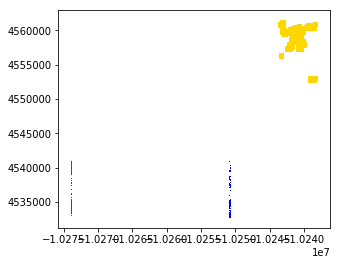

In [41]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
site1Candidates = site1Candidates[0:100]

site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
site2Candidates = site2Candidates[0:100]

airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))

Text(0.5,0.98,u'Demonstration of Epistasis: Candidate Sites by Index')

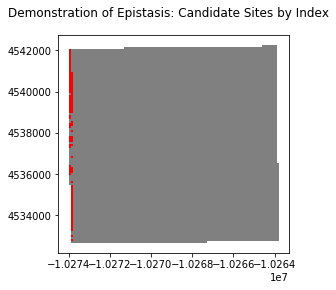

In [42]:
site1Candidates.plot(color='red',ax=site1SlopeEvaluationDataFrame.plot(color='grey'))
plt.suptitle("Demonstration of Epistasis: Candidate Sites by Index")

**Routing**

In [ ]:
reload(pgdissroute)

In [185]:
site1Candidates.crs = {"init":"EPSG:3857"}
site1Candidates_Projected = site1Candidates.to_crs({"init":"EPSG:4326"})

site2Candidates.crs = {"init":"EPSG:3857"}
site2Candidates_Projected = site2Candidates.to_crs({"init":"EPSG:4326"})

startLon = float(site1Candidates_Projected[0:1]['geometry'].centroid.x)
startLat = float(site1Candidates_Projected[0:1]['geometry'].centroid.y)

endLon = float(site2Candidates_Projected[0:1]['geometry'].centroid.x)
endLat = float(site2Candidates_Projected[0:1]['geometry'].centroid.y)

#startLon,startLat,endLon,endLat = -92.068859,37.846720,-92.142373,37.557935
df,m = pgdissroute.route(startLon,startLat,endLon,endLat)

In [186]:
m

In [184]:
sum(df['length_m'])

31218.236738914948